In [327]:
import os
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

Vocabluary

- ``` 'bout' ```: A complete sequence of medication-taking actions, varying in length.
- ``` 'window' ```: A subsection of time with length 'window_len', sampled from the bout.
- ``` 'stride' ```: The step size used to move to the right within the bout after sampling the first window.
- ``` 'flatten (bool)' ```: If True, each window’s x, y, and z values are combined into a single long array. 
  If False, each window is a ``` 3 x window_size ``` array with separate arrays for x, y, and z.
"""

In [328]:
save_dir = '/home/kuba/Documents/Data/Datasets/Listerine'
raw_data_dir = '/home/kuba/Documents/Data/Raw/Listerine/3_final'

window_size = 300
stride = 50
flatten = True

labels_to_one_hot = {
    'leftWater' : [[0],[0],[0],[1]],
    'leftLister' : [[0],[0],[1],[0]],
    'rightWater' : [[0],[1],[0],[0]],
    'rightLister' : [[1],[0],[0],[0]]

}

label_mapping = [
    ('left', 'water', 'leftWater'),
    ('left', 'listerine', 'leftLister'),
    ('right', 'water', 'rightWater'),
    ('right', 'listerine', 'rightLister')
]

In [329]:
def get_first_line(path):
    f = open(path)
    first_line = int(f.readline().strip().split(':')[1])
    return first_line

In [330]:
def window_maker(data, window_size, stride, flatten):
    #flatten (bool): If True it combines x,y,z data into single list
    res = []
    if flatten:
        # make windows
        for i in range(0, len(data['x'].tolist()) - window_size + 1, stride):
            combined = []
            combined.extend(data['x'][i:i + window_size].tolist())
            combined.extend(data['y'][i:i + window_size].tolist())
            combined.extend(data['z'][i:i + window_size].tolist())
            res.append(combined)
    else:
        for i in range(0, len(data['x'].tolist()) - window_size + 1, stride):
            combined = []
            combined.append(data['x'][i:i + window_size].tolist())
            combined.append(data['y'][i:i + window_size].tolist())
            combined.append(data['z'][i:i + window_size].tolist())
            res.append(combined)
    return res

In [331]:
def recording_accumulator(acc, gyro, labels, window_size, stride, flatten):
    # Splits accelerometer and gyroscope data into segments based on activity labels
    # Returns lists of these data segments and their labels
    acc_bouts, gyro_bouts, y = [], [], []
    
    for side, liquid, label_key in label_mapping:
        if side in labels and liquid in labels[side]:
            for label in labels[side][liquid]:
                new_acc = acc[(acc.timestamp > label['start']) & (acc.timestamp < label['end'])]
                new_gyro = gyro[(gyro.timestamp > label['start']) & (gyro.timestamp < label['end'])]  

                if len(new_acc) >= window_size: #check if we can even get one window out of the bout of activity
                    bouts_windows_acc = window_maker(new_acc, window_size, stride, flatten)#all the windows for a given bout
                    bouts_windows_gyro = window_maker(new_gyro, window_size, stride, flatten)

                    if len(bouts_windows_gyro) != len(bouts_windows_acc):
                        #print(f'ERROR: gyro {len(bouts_windows_gyro)} acc {len(bouts_windows_acc)}')
                        bouts_windows_gyro = bouts_windows_gyro[:-1]
                        #print(f'fixed so: gyro {len(bouts_windows_gyro)} acc {len(bouts_windows_acc)}')


                    acc_bouts.extend(bouts_windows_acc)
                    gyro_bouts.extend(bouts_windows_gyro)
                
                    y.extend([labels_to_one_hot[label_key]] * len(bouts_windows_acc))
    
    return acc_bouts, gyro_bouts, y

In [332]:
def participant_accumulator(dir, window_size, stride, flatten):
    acc_full = []
    gyro_full = []
    y_full = []

    for recoding in sorted(os.listdir(dir)):
        if recoding != '.DS_Store':
            full_path = os.path.join(dir,recoding)
            f = open(os.path.join(full_path,'labels.json'))
            labels = json.load(f)
            acc = pd.read_csv(os.path.join(full_path,'acceleration.csv'), skiprows=1)
            acc['timestamp']  = (acc['timestamp'] - acc['timestamp'].iloc[0]) * 1e-9 #subtract the start to get first time to be zero then convert from nano to sec
            #first_row_acc = get_first_line(os.path.join(full_path, 'acceleration.csv'))

            gyro = pd.read_csv(os.path.join(full_path,'gyroscope.csv'), skiprows=1)
            gyro['timestamp']  = (gyro['timestamp'] - gyro['timestamp'].iloc[0]) * 1e-9 #subtract the start to get first time to be zero then convert from nano to sec
            #first_row_gyro = get_first_line(os.path.join(full_path, 'gyroscope.csv'))
            # print(labels)


            acc, gyro, y = recording_accumulator(acc, gyro, labels, window_size, stride, flatten)
            acc_full.extend(acc)
            gyro_full.extend(gyro)
            y_full.extend(y)
        
    return acc_full, gyro_full, y_full

In [333]:
def validate(X_acc, X_gyro, y):
    print(f"X_acc shape: {len(X_acc)}x{len(X_acc[0])}")
    print(f"X_gyro shape: {len(X_gyro)}x{len(X_gyro[0])}")
    print(f"y shape: {len(y)}")


    X_acc = torch.tensor(X_acc)
    X_gyro =torch.tensor(X_gyro)
    y = torch.tensor(y)
    print(f'acc shape: {X_acc.shape} X gyro shape: {X_gyro.shape} y shpae: {y.shape}')
    

In the below block is where we would go through and save for each person, but this is just test code that we will use this code we built out in the data builder in the code

In [ ]:
for dir in sorted(os.listdir(raw_data_dir)):
    if dir != '.DS_Store':
        print(f'{dir}')
        X_acc, X_gyro, y = participant_accumulator(os.path.join(raw_data_dir,dir), window_size, stride, flatten)
        validate(X_acc, X_gyro, y)
        break
    '''
    THIS HERE
    '''
        

00
X_acc shape: 669x900
X_gyro shape: 669x900
y shape: 669
acc shape: torch.Size([669, 900]) X gyro shape: torch.Size([669, 900]) y shpae: torch.Size([669, 4, 1])


---
Now lets find out the distribution of the lengths of each bout. 

In [335]:
def label_len_calc(dir):
    water_lens = []
    lister_lens = []

    for recoding in sorted(os.listdir(dir)):
        if recoding != '.DS_Store':
            full_path = os.path.join(dir,recoding)
            f = open(os.path.join(full_path,'labels.json'))
            labels = json.load(f)

            #for each person recodings
            for side, liquid, label_key in label_mapping:
                if side in labels and liquid in labels[side]:
                    for label in labels[side][liquid]:
                        if liquid == 'water':
                            water_lens.append(label['end'] - label['start'])
                        else:
                            lister_lens.append(label['end'] - label['start'])

    return water_lens, lister_lens

full_water_lens = []
full_lister_lens = []

for dir in sorted(os.listdir(raw_data_dir)):
    if dir != '.DS_Store':
        water_lens, lister_lens = label_len_calc(os.path.join(raw_data_dir,dir))
        full_water_lens.extend(water_lens)
        full_lister_lens.extend(lister_lens)


In [336]:
def remove_outliers(data, thresh=5.5):
    data = np.array(data).ravel()
    median = np.median(data)
    
    diff = np.abs(data - median)
    mad = np.median(diff)
    modified_z_score = 0.6745 * diff / mad
    mask = modified_z_score <= thresh
    
    return data[mask]

In [337]:
#remove outliers
full_water_lens = remove_outliers(full_water_lens)
full_lister_lens = remove_outliers(full_lister_lens)

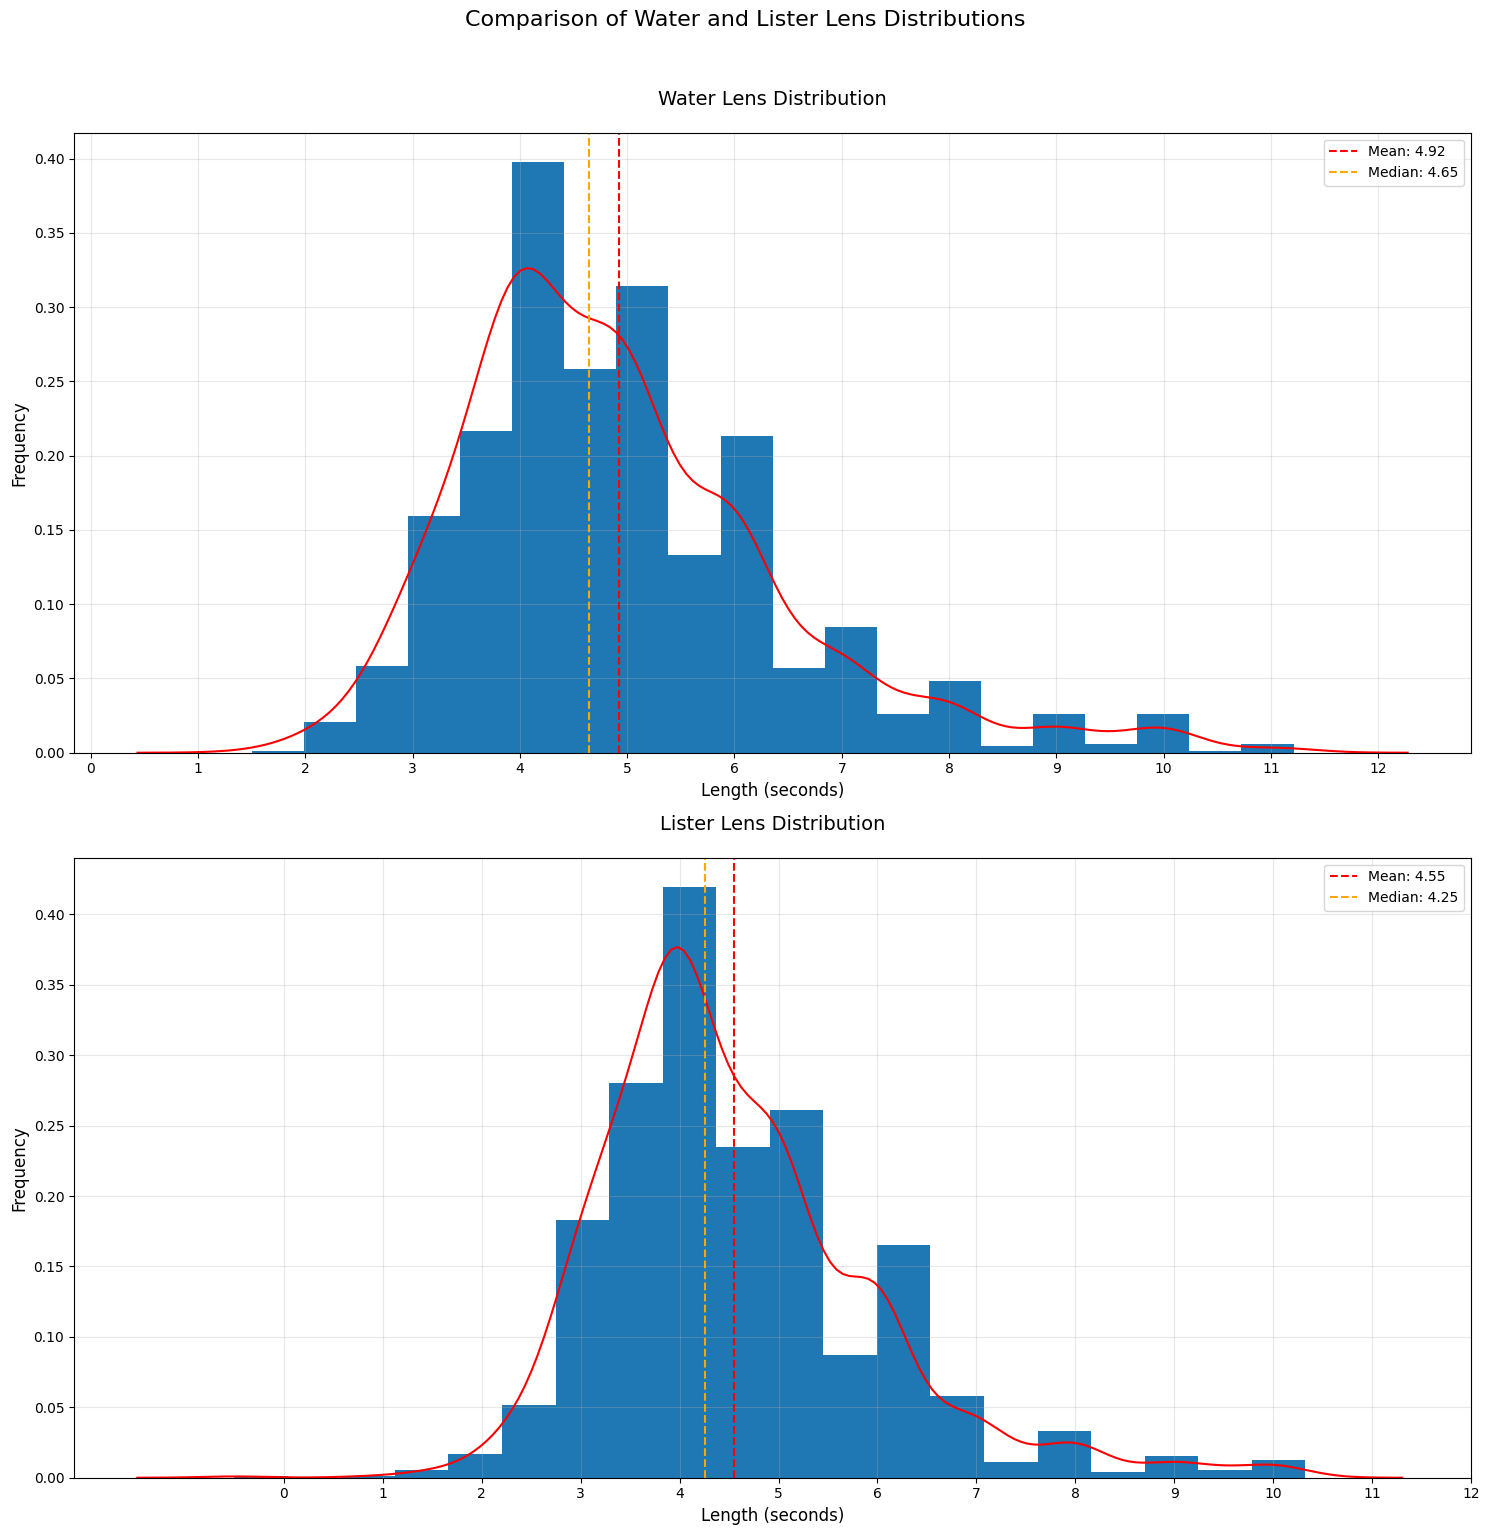

In [338]:
bin_num = 20  # Increased bins for better resolution
titles = ['Water Lens Distribution', 'Lister Lens Distribution']
data_sets = [full_water_lens, full_lister_lens]

fig, axs = plt.subplots(2, 1, figsize=(15, 15))

for i, (ax, data, title) in enumerate(zip(axs, data_sets, titles)):
    mean = np.mean(data)
    median = np.median(data)
    std = np.std(data)

    ax.hist(data, bins=bin_num, density=True)
    sns.kdeplot(data, color='r', ax=ax)
    ax.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')
    ax.axvline(median, color='orange', linestyle='--', label=f'Median: {median:.2f}')

    ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12]) 

    ax.set_title(title, fontsize=14, pad=20)
    ax.set_xlabel('Length (seconds)', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.grid(True, alpha=0.3)

    ax.legend()


plt.suptitle('Comparison of Water and Lister Lens Distributions', fontsize=16, y=1.02)
plt.tight_layout()

plt.show()